<a href="https://colab.research.google.com/github/MathewS424/DeepLearning_with_PyTorch/blob/main/04_PyTorch_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets

## 0.Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu121'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1.Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

#Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... kipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip piza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


## 2.Becoming one with the data (data preparation and data exploration)

In [4]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


### 2.1 Visualizing image
Let's write some code to:

1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/train/pizza/1008844.jpg
Image class: pizza
Image height: 512
Image width: 512


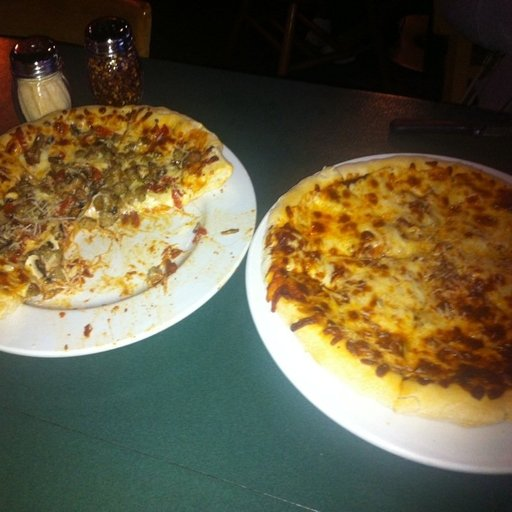

In [8]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img